## Small SGHMC demo

In [1]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Suppose we want to sample from a Normal Distribution. We need to specify the log-density function.

In [117]:
class NomalDist:
    def __init__(self, mu, sigma):
        self.d = mu.size
#         sigma_cho = np.linalg.cholesky(sigma)
        self.mu = Variable(torch.from_numpy(mu).float())
        self.sigma = Variable(torch.from_numpy(sigma.dot(sigma.T)).float())
        self.sigma_inv = torch.inverse(self.sigma)
#         self.sigma_cho = Variable(torch.from_numpy(sigma_cho).float())
        
    def loss(self, x):
        return torch.matmul(torch.transpose(x - self.mu[:, None], 0, 1), 
                            torch.matmul(self.sigma_inv, (x - self.mu[:, None])))
    
    def sample(self, n_samples):
        z = Variable(torch.randn((n_samples, self.d)).float())
        samples = torch.transpose(torch.matmul(self.sigma, torch.transpose(z, 0, 1)), 0, 1)
        samples += self.mu[None, :] 
        return samples.data.numpy()

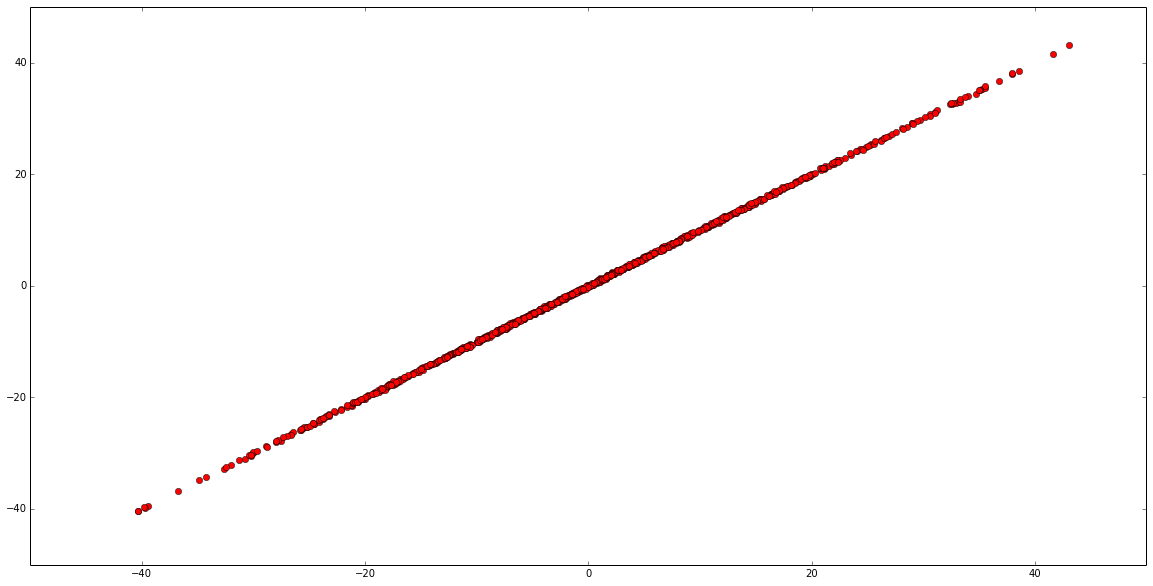

In [94]:
plt.figure(figsize=(20, 10))
mu = np.zeros([2], dtype=float)
sigma = np.array([[10, 9.9], [9.9, 10]])
dist = NomalDist(mu, sigma)
original_samples = dist.sample(1000)
plt.plot(original_samples[:, 0], original_samples[:, 1], 'ro')

The SGHMC sampler

In [96]:
class SGHMC:
    
    def __init__(self, var, alpha, eta, log_density):
        """
        Stochastic Gradient Monte Carlo sampler.
        
        Args:
            var: `Variable` corresponding to the variable that is sampled
            alpha: momentum parameter
            eta: learning rate parameter
            log_density: function computing log_density for a given sample
                and batch of data
        """
        self.var = var
        self.alpha = alpha
        self.eta = eta
        self.log_density = log_density
        self.optimizer = optim.SGD([self.var], lr=1, momentum=(1 - self.alpha))
    
    def _noise(self):
        std = np.sqrt(2 * self.alpha * self.eta)
        n = Variable(torch.normal(0, std= std * torch.ones(self.var.size())))
        return torch.sum(n * self.var)
        
    def sample(self):
#         print "Log Density:" self.log_density(self.var).shape
        
        loss = self.log_density(self.var) * self.eta
        loss += self._noise()
        loss.backward()
        self.optimizer.step()
        self.var.grad.data.zero_()
        return self.var

In [97]:
x = torch.from_numpy(np.array([[-10], [0]])).float()
x_v = Variable(x, requires_grad=True)
mu = np.zeros([2], dtype=float)
sigma = np.array([[10, 9.9], [9.9, 10]])
dist = NomalDist(mu, sigma)
# sghmc = SGHMC(x_v, alpha=1., eta=5e-3, log_density=dist.loss)
sghmc = SGHMC(x_v, alpha=0.01, eta=5e-3, log_density=dist.loss)

In [98]:
samples = []
for epoch in range(10000):
    w_sample = sghmc.sample()
    samples.append(np.copy(w_sample.data.numpy()).T)
    if not(epoch % 1000):
        print(epoch)
        
samples = np.vstack(samples)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


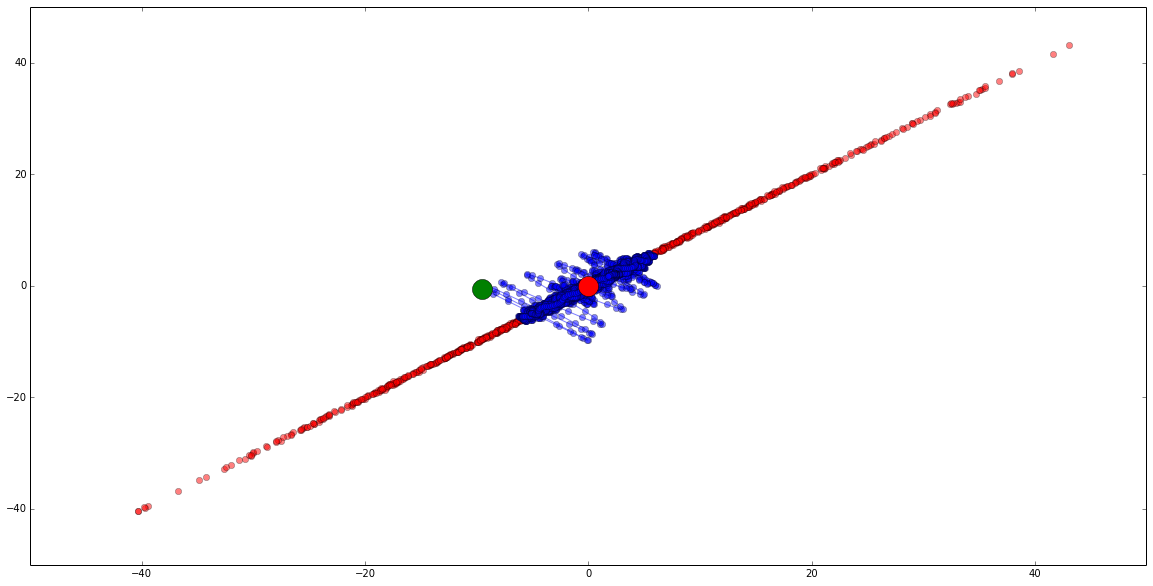

In [99]:
plt.figure(figsize=(20, 10))
start_from=0
plus = 10000
plt.plot(original_samples[:, 0], original_samples[:, 1], 'ro', alpha=0.5)
plt.plot(samples[start_from:start_from+plus, 0], samples[start_from:start_from+plus, 1], '-bo', alpha=0.5)
plt.plot(samples[0, 0], samples[0, 1], 'go', ms=20)
plt.plot(mu[0], mu[1], 'ro', ms=20)

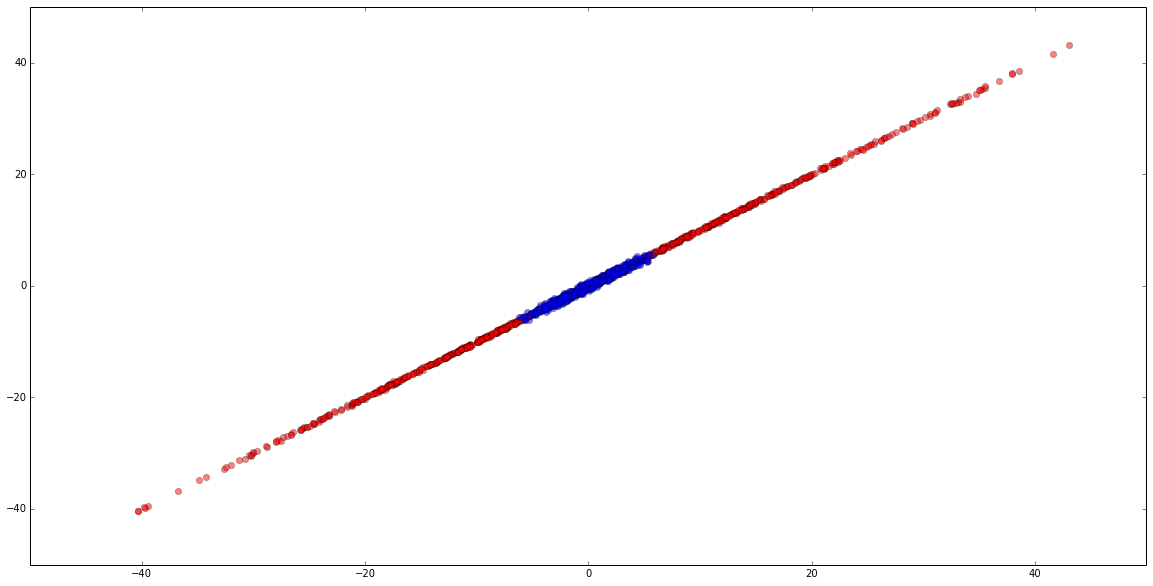

In [100]:
plt.figure(figsize=(20, 10))
freq = 10
new_samples = []
for i in range(int(samples.shape[0] / freq))[100:]:#[400:]:
    new_samples.append(samples[i * freq][None, :])
new_samples = np.vstack(new_samples)
plt.plot(original_samples[:, 0], original_samples[:, 1], 'ro', alpha=0.5)
plt.plot(new_samples[:, 0], new_samples[:, 1], 'bo', alpha=0.5)


In [15]:
import torch.nn as nn
import torch.optim as optimizer
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as transforms

from IPython.display import Image
import matplotlib.pyplot as plt

In [16]:
# LeNet Pytorch
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet,self).__init__()
        #Define layers
        
        # subsampling will occur, then you do next convolution

        # 6 feature maps, size 28x28
        # conv1 needs 1 image, 6 filers, and will do 5x5 convolution
        # will return 28x28
        
        # first conv layer, so only one channel
        self.conv1 = nn.Conv2d(1,6,kernel_size=5)
        
        # subsample will occur in forward(), then conv
        # 16 feature maps, 10 x 10 image size
        
        # next layer will grab 6 filters and give you 16 filters
        # kernel size is 5 x 5
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)#
        
        # fully connected layers compute an affine operation: y = Wx + b
        
        # process through three fully connected layers
        # fc1: 16*5*5(400) input -> 120 output
        # fc2: 120 input -> 84 output
        # fc3: 84 input -> 10 classes output
        
#         self.fc1 = nn.Linear(16*5*5,120)# if input is 32*32
    
        self.fc1 = nn.Linear(16*4*4,120)# input is 28*28
        self.fc2 = nn.Linear(120,84)# why did not add number of classes?
        self.fc3 = nn.Linear(84,10)
        

    def forward(self,x):
        #Here define how input gets processed along network
        
        out = self.conv1(x)# convolution, returns (6,28,28)
        out = nn.functional.relu(out)# non linear
        out = nn.functional.max_pool2d(out,(2,2))# subsample, get (6,14,14)

        # convolution
        out = self.conv2(out)#returns (16,10,10)
        # non-linear
        out = nn.functional.relu(out)
        # subsample
        out = nn.functional.max_pool2d(out,2)# returns (16,5,5)
        # reshape 3D layer to a layer of neurons row by row
#         print out.size()
        out = out.view(-1,self.num_flatten_layers(out))#now have tensor of (400)
#         print out.size()
        # fc1 and non-linear relu
        out = nn.functional.relu(self.fc1(out))# non-linear transform 400->120
        # fc2 and non-linear relu
        out = nn.functional.relu(self.fc2(out))# non-lin transform 120 -> 84
        out = nn.functional.relu(self.fc3(out))# non-lin transform 84 -> 10
        return out
    
    def num_flatten_layers(self,x): # all dimensions except the batch dimension
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [20]:
lenet = LeNet()
print lenet

LeNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [18]:
train_dataset = dsets.MNIST(root='../data',
                           train=True,
                           transform = transforms.ToTensor(),
                           download=False)

test_dataset = dsets.MNIST(root='../data',
                          train=False,
                          transform= transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=100,
                         shuffle = True,
                         num_workers = 2)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size = 100,
                        shuffle=False)

Processing...
Done!


In [21]:
criterion = optimizer.SGD(lenet.parameters(),lr=0.5)
# Adam(lenet.parameters(),lr=0.001)
loss = nn.CrossEntropyLoss()

In [22]:
# NOTE 2: Tensorflow shows in tutorial 10,000  to 20,000 epochs!
num_epochs = 1
didPrintStep_size = False
for epoch in range(num_epochs):
    for i,(batch_input, batch_labels) in enumerate(train_loader):
        
        #convert batch tensor to variable
        batch_input = Variable(batch_input)
#         print batch_input.size()
#         print batch_labels.size()
        batch_labels = Variable(batch_labels)
        
        lenet.zero_grad()
        output = lenet(batch_input)
        lossRes = loss(output,batch_labels)
        lossRes.backward()
        criterion.step()
        
        # append loss
        
        
        if didPrintStep_size==False:
            print "Num of steps in epoch: ",str(len(train_dataset)/100)
            print "Num of steps to run: ",str( (len(train_dataset)/100)*num_epochs )
            didPrintStep_size=True
        if i%100 ==0:#completed 100 steps
            print ('Epoch[%d,%d], Step[%d/%d], Loss %.4f'%(epoch-1,num_epochs,i,len(train_dataset)/100,lossRes.data[0]))
        
        

Num of steps in epoch:  600
Num of steps to run:  600
Epoch[-1,1], Step[0/600], Loss 2.3024
Epoch[-1,1], Step[100/600], Loss 2.0849
Epoch[-1,1], Step[200/600], Loss 1.3387
Epoch[-1,1], Step[300/600], Loss 0.9867
Epoch[-1,1], Step[400/600], Loss 0.5728
Epoch[-1,1], Step[500/600], Loss 0.7486


In [23]:
# Test classifier

'''
For each image in test_loader:
    - convert to variable
    - output = lenet(image)
    - get index of max element for each row (data)
    - get total - labels.size
    - compute number of images correct
'''
print "length of train dataset(# of 100 batches): "+str(len(train_loader))
total = 0
correct = 0
for images,label in test_loader:
    inputs = Variable(images)
    output = lenet(inputs)
    # get num of labels equal to batch size
    # i.e. get 100 predictions
    _,predictedLabels = torch.max(output.data,1)#get max along axis=1, columns
#     print predictedLabels.size()
    total +=label.size(0)# Tensor
#     print total
    correct += (predictedLabels==label).sum()
    
print ("%d correct, %d total, Acc = %.2f")%(correct,total,correct/float(total))
    

length of train dataset(# of 100 batches): 600
8489 correct, 10000 total, Acc = 0.85


In [48]:
# [p. for p in lenet.named_parameters()]
param = list(lenet.parameters())
print [n[0] for n in lenet.named_parameters()]
print len(param)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
10


In [72]:
print param[0].data.numpy().shape

(6, 1, 5, 5)


In [84]:
a = np.dstack([np.identity(5),np.identity(5),np.identity(5),np.identity(5),np.identity(5),np.identity(5)])

In [87]:
a = a.reshape(6,1,5,5)

In [106]:
param[-2].data.numpy().shape

(10, 84)

In [125]:
mu = np.zeros(param[-2].data.numpy().shape, dtype=float)
sigma = np.random.random(param[-2].data.numpy().shape)
dist = NomalDist(mu, sigma)

sghmc1 = SGHMC(param[-1], alpha=0.01, eta=5e-3, log_density=dist.loss)
sghmc2 = SGHMC(param[2], alpha=0.01, eta=5e-3, log_density=dist.loss)

In [126]:
samples = []
for epoch in range(10000):
    w_sample = sghmc1.sample()
#     w_sample2 = sghmc2.sample()
    samples.append(np.copy(w_sample.data.numpy()).T)
    if not(epoch % 1000):
        print(epoch)
        
samples = np.vstack(samples)

RuntimeError: inconsistent tensor size, expected r_ [10], t [10] and src [10 x 1 x 84] to have the same number of elements, but got 10, 10 and 840 elements respectively at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:887